# this notebook parse patch data
# TODO: meet with Venu to confirm the changes I made



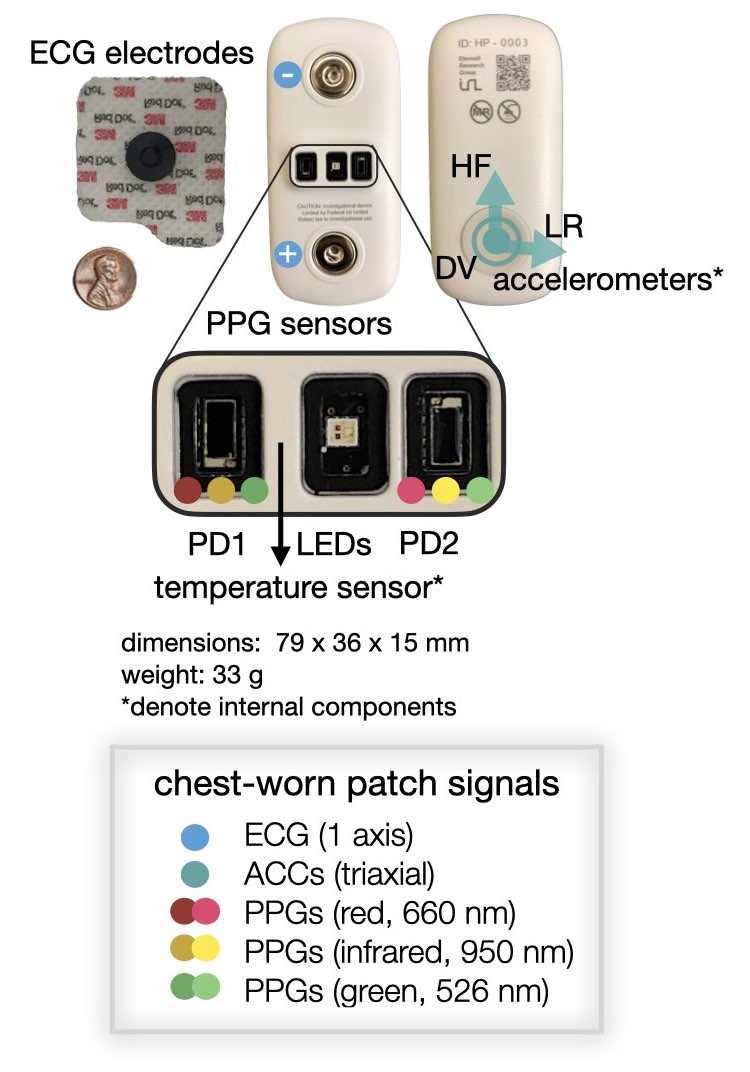





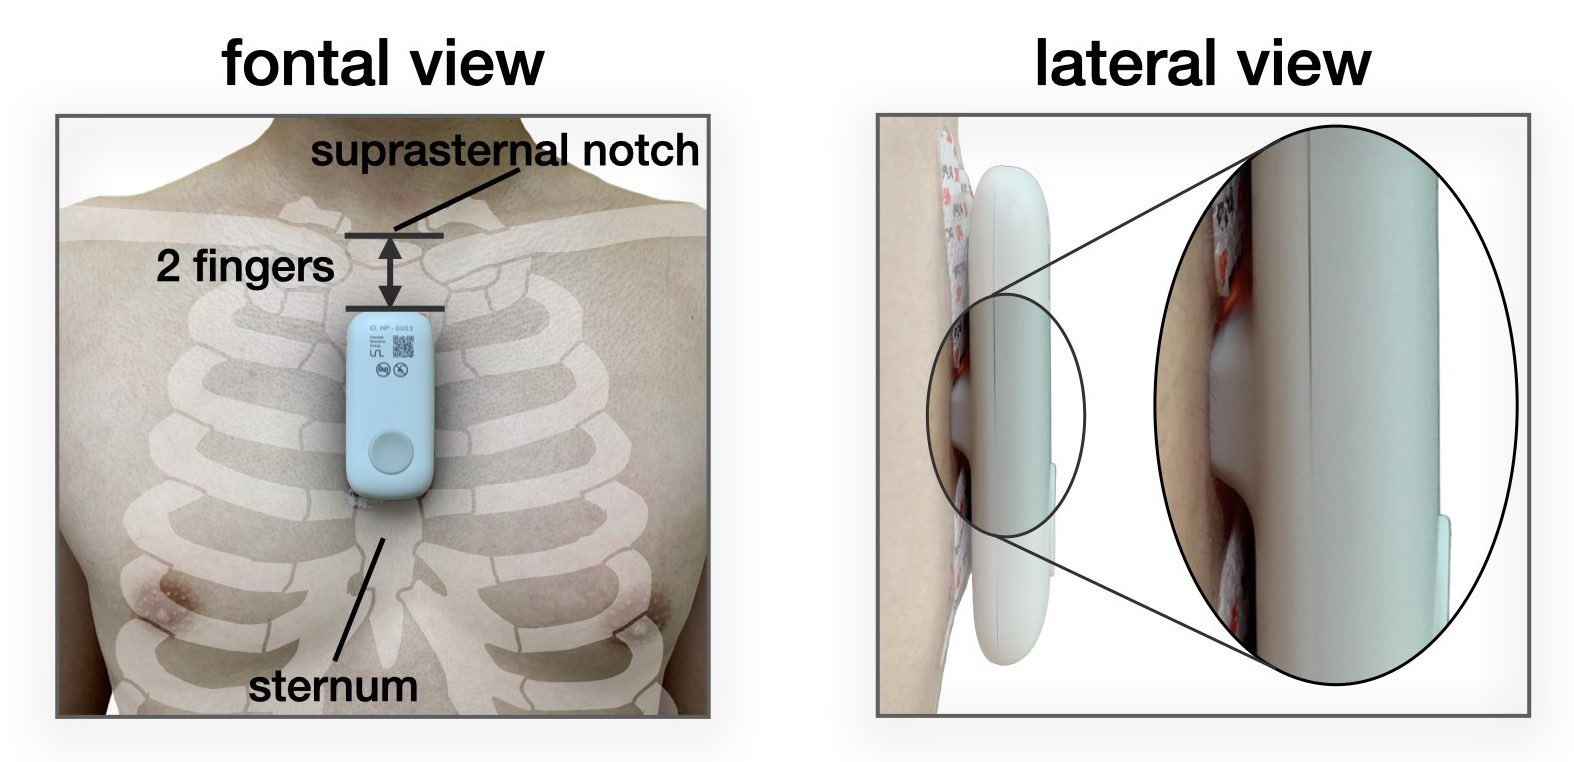

In [5]:
import numpy as np
import argparse

import os
import math
from math import sin

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
from plotting_tools import *
from stage1_patch import *

from scipy.interpolate import interp1d
from scipy.io import savemat
from importlib import reload
%load_ext autoreload
%autoreload 2

In [6]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--log_wandb', metavar='log_wandb', help='log_wandb',
                    default=True)
parser.add_argument('--ignore_past', metavar='ignore_past', help='ignore_past',
                    default=False)
parser.add_argument('--participant_number', metavar='participant_number', help='participant_number',
                    default='0000')

# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../fully_supervised/raw_data/', 
                          '--output_folder', '../fully_supervised/data/',
                          '--participant_number', '003'
                         ])
# args = parser.parse_args()
print(args)

Namespace(ignore_past=False, input_folder='../fully_supervised/raw_data/', log_wandb=True, output_folder='../fully_supervised/data/', participant_number='003')


In [7]:

inputdir = args.input_folder
outputdir = args.output_folder + args.participant_number 

log_wandb = args.log_wandb # boolean
ignore_past = args.ignore_past # boolean
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

In [8]:
fileName = inputdir+'003/HP-0224_20211123_220214.bin'
fileName

'../fully_supervised/raw_data/003/HP-0224_20211123_220214.bin'

# 1. compute sensitivity (responsivity)

## step 1. extract datapoints from the plots (stored in X and Y in the later cell)

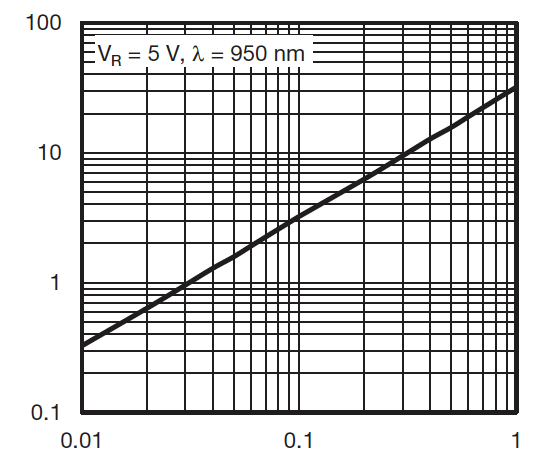# 

</br>

**source: VEMD8080 dataset Fig3**

## In this log-log plot, log I and log E appear to be in a linear relationship
## log (I) = m x log (E) + b
## find $m^{*}, b^{*}$

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression

# these datapoints are extracted from the PPG sensor datasheet
X = np.log(np.array([0.01, 0.04, 0.1, 0.5, 1]))[:,None]
Y = np.log(np.array([0.33, 1.29, 3.22, 15.72, 31.72]))
reg = LinearRegression().fit(X, Y)
print(reg.coef_[0], reg.intercept_)

0.9907316466170134 3.4493477785841598


In [10]:
np.exp(reg.intercept_)

31.479853776840056

## since the power is close to 1 (m), the linear relationship also holds in linear space because....
## $m^{*}≈1, b^{*}≈3.45$

## so log (I) ≈ 1 x log (E) + 3.45
## take exponential
## I ≈  e^(3.45) * E


## I (in μA) ≈ 31.48 * E (in mW/$cm^{2}$)

## a line is considered to have a unity power when m is 1. 

## R = I/P = [ 1 uA x (10^-6 A/uA) ]  / [ 1 (mW/cm2) x (10^-3 W/mW) x (0.01 cm2/mm2) x 4.55mm2 ]
## R = 7.06e-4 (A/W)

where P = E * area (area can be found in the datasheet)

In [11]:
import math

R_950 = 1 * 1e-6 / (31.48 * 1 * 1e-3 * 1e-2 * 4.55)
R_950

0.0006981582585140399

# 1. parse data (bin->npy)

> ## for all of the ppg signals multiply their raw signals by 61e-6 (this will convert them from bits into uA), </br>
> ## for the red and IR signals subtract 8 uA from the signals after the conversion to account for the PD bias of 8 uA. Please make these changes to all the readW4 python files so its there the moment we are converting the binary files

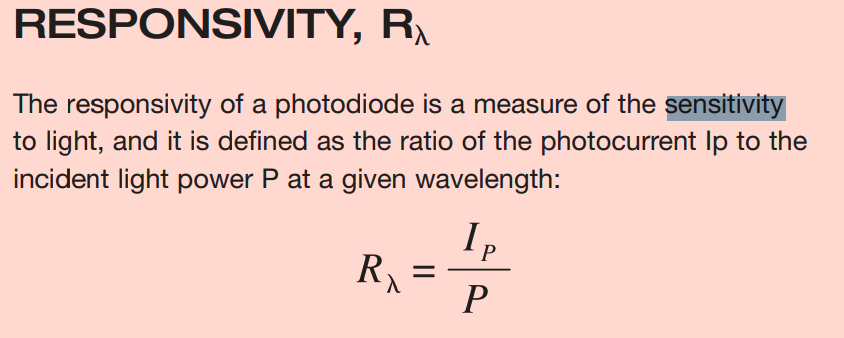

# R_lamda is extracted from the image in VEMD8080 datasheet 
I = current, P = power

P = I/R

In [12]:
R_lamda_relative = {
    'green': 0.622, # 526nm
    'red': 0.828, # 660nm
    'infrared': 0.825, # 950 nm
}

R_lamda = {} # the unit is A/W

for key in R_lamda_relative:
    R_lamda[key] = R_lamda_relative[key] * R_950 / R_lamda_relative['infrared']

R_lamda

{'green': 0.000526369014297858,
 'red': 0.0007006970158177274,
 'infrared': 0.0006981582585140399}

In [13]:
for key in R_lamda_relative:
    print(R_lamda_relative[key] / R_lamda[key]) 

1181.6805
1181.6805
1181.6805000000002


In [14]:
def PPGunit_conversion(ppg, wavelength, c_PDbias):
    # return ECG values in uW
    # editted 11/17. Don't need to adjust for bias based on firmware_id anymore
#     if firmware_id == 0:
#         c_PDbias = 8 # uA
#     else:
#         c_PDbias = 0 # uA
    
    # TODO: ask venu how to set this parameter
#     c_PDbias = 0 # uA

    c_bits2uA = 61e-6 # uA/bits
    
#     ppg_uA = ((ppg*c_bits2uA)-c_PDbias) # uA
    # TODO: ask venu if the unit of the current is in nA
    ppg_uA = ppg*c_bits2uA-c_PDbias/1000 # (b/c nA = 1e-3 uA)

#     ppg_uW = ppg_uA / R_lamda_relative[wavelength] #uW
    ppg_uW = ppg_uA / R_lamda[wavelength] # uW = uA / (A/W)
    return ppg_uW


# def PPGunit_conversion(ppg, firmware_id, wavelength):
    
#     if firmware_id == 0:
#         c_PDbias = 8 # uA
#     else:
#         c_PDbias = 0 # uA
    
#     c_bits2uA = 61e-6 # uA/bits
    
#     ppg_uA = ((ppg*c_bits2uA)-c_PDbias) # uA
# #     ppg_uW = ppg_uA / R_lamda_relative[wavelength] #uW
#     ppg_uW = ppg_uA / R_lamda[wavelength] # uW = uA / (A/W)
#     return ppg_uW



In [15]:
def ECGunit_conversion(ecg):
    # return ECG values in V
    # Data formatt pg 28 ads1291
    # Figure the conversion factor for counts to volts
    ecg_gain = 8
    ecg_vRef = 2.42
#     ecg_volts_per_bit = (ecg_vRef/ecg_gain)/(2^23-1) # (V/bit)
    ecg_volts_per_bit = (ecg_vRef/ecg_gain)/(2**23-1) # (V/bit)
    # Convert to volts
    ecg = (ecg * ecg_volts_per_bit) # V
    return ecg

In [16]:
def ACCunit_conversion(acc):
    # return ACC values in g
# adxl 355 pg 4 (sensitiivity)
    # editted 11/17. Remove 16 so it can be coverted to g
    acc = acc / 256000 # g
    #  (acc has 20 bit, need to bit shift by 12 to get int32, 
    # 256000 => LSB/g ???    
    return acc

# def ACCunit_conversion(acc):
# # adxl 355 pg 4 (sensitiivity)
#     acc = acc / 16 / 256000 # mg
#     #  (acc has 20 bit, need to bit shift by 12 to get int32, 
#     # 256000 => LSB/g ???    
#     return acc

In [17]:
import numpy as np
import sys
import time
import struct
import datetime

def bytetoint(byte):
    if byte > 127:
        return byte - 256
    else:
        return byte
    
def bytestoint(byte):
    data = byte[0]*256 + byte[1]
    if data > 32767:
        return data - 65536
    else:
        return data

def parse(data, header = True, print_updates = False, isConvUnits = True):
    """
    This is the parsing script provided by Cardiosense 
    Author: Michael Chan (mchan81@gatech.edu)
    Cardiosense rep: Venu Ganti (venu@cardiosense.com)
    
    TODO: This code is still not very well organized. Please package this script better.
    Versions 1.1.0
    
    Input:
        fileContent - bytes read from the file
        header - bytes read from the file
        print_updates - print parsing information (e.g., speed, data size, etc.)
        isConvUnits - if True, converts acceleration binary code to accleration units (g)

    Usage:
        file = open(fileName, mode='rb') # open the .bin file exported from the patch using the Cardiosense software
        fileContent = file.read() # specified number of bytes from the file
        patch_dict = parse(fileContent, header = True, print_updates = True, isConvUnits = True)

    Release Notes:
        Version 1.0.0 (2022): Initial release
        Version 1.1.0 (2023/02/25): Fixed an issue, Red and Green PPG are swapped. In your own dataset, please check the perfusion index (PI) of your subjects during baseline. For your reference: Range of PI for red ≈ [0.05, 0.07]. Range of PI for green ≈ [0.56, 0.6]. Range of PI for infrared ≈ [0.08, 0.10]. All of the changes can be found by searching the key word "Edited on 2023/02/25"
    """

    time1 = time.time()

    AST_SR = 16384/(2*2)
       
    ts = int.from_bytes(data[50:58], "big")
    dt = datetime.datetime(1601, 1, 1, 0, 0, 0) + datetime.timedelta(seconds = ts/1e7)
    dt.ctime()

    if(header and not(dt < datetime.datetime.utcnow() < dt + datetime.timedelta(hours = 3*365*24))):
        data = data[512:]
       
        ts = int.from_bytes(data[50:58], "big") # try with offset
        dt = datetime.datetime(1601, 1, 1, 0, 0, 0) + datetime.timedelta(seconds = ts/1e7)
        dt.ctime()

   
    accel_size = int.from_bytes(data[58:62], "little")
    ppg_size = int.from_bytes(data[62:66], "little")
    ecg_size = int.from_bytes(data[66:70], "little")
    env_size = int.from_bytes(data[70:74], "little")
    ast_time = int.from_bytes(data[85:89], "little")
   
    devName = data[74:84].decode('latin1').split("\x00")[0]
   
    ecg = np.zeros(ecg_size) #[None] * 10000000
    ecg_time = np.zeros(ecg_size) #[None] * 10000000
    ecg_count = 0;

    accel_x = np.zeros(accel_size) #[None] * 10000000
    accel_y = np.zeros(accel_size) #[None] * 10000000
    accel_z = np.zeros(accel_size) #[None] * 10000000
    accel_time = np.zeros(accel_size) #[None] * 10000000
    accel_count = 0;

    ppg_ir_1_tag = np.zeros(ppg_size)
    ppg_g_1 = np.zeros(ppg_size) #[None] * 10000000
    ppg_r_1 = np.zeros(ppg_size) #[None] * 10000000
    ppg_ir_1 = np.zeros(ppg_size) #[None] * 10000000
    ppg_g_1_current = np.zeros(ppg_size)
    ppg_r_1_current = np.zeros(ppg_size)
    ppg_ir_1_current = np.zeros(ppg_size)
    ppg_time = np.zeros(ppg_size) #[None] * 10000000
    ppg_count = 0
   
    ppg_g_2 = np.zeros(ppg_size) #[None] * 10000000
    ppg_r_2 = np.zeros(ppg_size) #[None] * 10000000
    ppg_ir_2 = np.zeros(ppg_size) #[None] * 10000000
    ppg_g_2_current = np.zeros(ppg_size)
    ppg_r_2_current = np.zeros(ppg_size)
    ppg_ir_2_current = np.zeros(ppg_size)
   
    temp_skin = np.zeros(env_size) #[None] * 10000000
    pres = np.zeros(env_size)
    temp_internal = np.zeros(env_size)
    env_time = np.zeros(env_size)
   
    if print_updates:
        sys.stdout.write("Device name: " + devName + "\n")
        sys.stdout.write("Last sync time: " + dt.ctime() +" UTC\n")
        sys.stdout.write("Accel Size: " + str(accel_size) +"\n")
        sys.stdout.write("PPG Size: " + str(ppg_size) +"\n")
        sys.stdout.write("ECG Size: " + str(ecg_size) +"\n")
        sys.stdout.write("Environmental Size: " + str(env_size) +"\n")
        sys.stdout.write("AST Time Length: " + str(ast_time/AST_SR) +"\n")
   
    dataSize = len(data) - 512
    ind = 512
    indCount = 1000000;
    indStep = 1000000;
    time_temp = 0;
    compressCount = 0;
    ecgCompressCount = 0;
    accelCompressCount = 0;
    astCompressCount = 0;
    envCount = 0
    while accel_count < accel_size - 80:  
        flag = data[ind]
        flag_ind = ind
        ind += 1
        if flag & 0x80:      
            time_temp += data[ind]/AST_SR
            ind += 1
            astCompressCount += 1
        else:
            time_temp = int.from_bytes(data[ind:ind+4], "little")/AST_SR
            ind += 4
        if flag & 0x01:
            if flag & 0x10:
                ecg[ecg_count] = ecg[ecg_count-1] + bytetoint(data[ind+1])
                ind += 2
                compressCount += 2
                ecgCompressCount += 1
            else:
                ecg[ecg_count] = int.from_bytes(b'\x00' + data[ind+1:ind+4], "little",signed=True) >> 8
                ind += 4
            ecg_time[ecg_count] = time_temp
            ecg_count += 1
        if flag & 0x02:
            if flag & 0x40:
                accel_x[accel_count] = accel_x[accel_count-1] + bytetoint(data[ind])
                ind += 1
                accel_y[accel_count] = accel_y[accel_count-1] + bytetoint(data[ind])
                ind += 1
                accel_z[accel_count] = accel_z[accel_count-1] + bytetoint(data[ind])
                ind += 1
                accelCompressCount += 2
                compressCount += 6
            elif flag & 0x20:
                accel_x[accel_count] = accel_x[accel_count-1] + bytestoint(data[ind:ind+2])
                ind += 2
                accel_y[accel_count] = accel_y[accel_count-1] + bytestoint(data[ind:ind+2])
                ind += 2
                accel_z[accel_count] = accel_z[accel_count-1] + bytestoint(data[ind:ind+2])
                ind += 2
                accelCompressCount += 1
                compressCount += 3
            else:
                accel_x[accel_count] = int.from_bytes(b'\x00' + data[ind:ind+3], "little",signed=True) >> 8
                ind += 3
                accel_y[accel_count] = int.from_bytes(b'\x00' + data[ind:ind+3], "little",signed=True) >> 8
                ind += 3
                accel_z[accel_count] = int.from_bytes(b'\x00' + data[ind:ind+3], "little",signed=True) >> 8
                ind += 3
            accel_time[accel_count] = time_temp
            accel_count += 1
        if flag & 0x04:
            ppg_ir_1[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            if ppg_ir_1[ppg_count] > 524288:
                ppg_ir_1[ppg_count] -= 1048576
            ind += 3
            # Red and Green were incorrectly labeled. Edited on 2023/02/25
            ppg_r_1[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            if ppg_r_1[ppg_count] > 524288:
                ppg_r_1[ppg_count] -= 1048576
            ind += 3
            # Red and Green were incorrectly labeled. Edited on 2023/02/25
            ppg_g_1[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            if ppg_g_1[ppg_count] > 524288:
                ppg_g_1[ppg_count] -= 1048576
            # ind += 3
            # ppg_g_1[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            # if ppg_g_1[ppg_count] > 524288:
            #     ppg_g_1[ppg_count] -= 1048576
            # ind += 3
            # ppg_r_1[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            # if ppg_r_1[ppg_count] > 524288:
            #     ppg_r_1[ppg_count] -= 1048576
                
                
            ind += 3
            ppg_ir_2[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            if ppg_ir_2[ppg_count] > 524288:
                ppg_ir_2[ppg_count] -= 1048576
            ind += 3
            # Red and Green were incorrectly labeled. Edited on 2023/02/25
            ppg_r_2[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            if ppg_r_2[ppg_count] > 524288:
                ppg_r_2[ppg_count] -= 1048576
            ind += 3
            # Red and Green were incorrectly labeled. Edited on 2023/02/25
            ppg_g_2[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            if ppg_g_2[ppg_count] > 524288:
                ppg_g_2[ppg_count] -= 1048576
            # ind += 3
            # ppg_g_2[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            # if ppg_g_2[ppg_count] > 524288:
            #     ppg_g_2[ppg_count] -= 1048576
            # ind += 3
            # ppg_r_2[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            # if ppg_r_2[ppg_count] > 524288:
            #     ppg_r_2[ppg_count] -= 1048576
            ind += 3
            ppg_time[ppg_count] = time_temp
            ppg_ir_1_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            ind += 1
            # Red and Green were incorrectly labeled. Edited on 2023/02/25
            ppg_r_1_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            # ppg_g_1_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            ind += 1
            # Red and Green were incorrectly labeled. Edited on 2023/02/25
            ppg_g_1_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            # ppg_r_1_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            ind += 1
            ppg_ir_2_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            ind += 1
            # Red and Green were incorrectly labeled. Edited on 2023/02/25
            ppg_r_2_current[ppg_count] = data[ind]
            # ppg_g_2_current[ppg_count] = data[ind]
            ind += 1
            # Red and Green were incorrectly labeled. Edited on 2023/02/25
            ppg_g_2_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            # ppg_r_2_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            ind += 1
            ppg_count += 1
        if flag & 0x08:
            temp_skin[envCount] = int.from_bytes(data[ind:ind+2], "big") * 0.005
            env_time[envCount] = time_temp
            ind += 2
            pres[envCount] = int.from_bytes(data[ind:ind+3], "little") / 4096
            ind += 3
            temp_internal[envCount] = bytestoint(data[ind+1:ind-1:-1]) / 100
            ind += 2
            envCount += 1
       
        if print_updates:
            if ind > indCount:
                indCount = indCount + indStep
                sys.stdout.write(str(ind) + " " + str(round(ind/len(data)*100, 2)) + "% done                      \r")
   
    ppg_time = ppg_time[0:ppg_count]
    ppg_g_1 = ppg_g_1[0:ppg_count]
    ppg_g_2 = ppg_g_2[0:ppg_count]
    ppg_r_1 = ppg_r_1[0:ppg_count]
    ppg_r_2 = ppg_r_2[0:ppg_count]
    ppg_ir_1 = ppg_ir_1[0:ppg_count]
    ppg_ir_2 = ppg_ir_2[0:ppg_count]

    # convert binary code to ppg units (uW)
    if (isConvUnits):
        ppg_g_1_current = ppg_g_1_current[0:ppg_count]
        ppg_g_2_current = ppg_g_2_current[0:ppg_count]
        ppg_r_1_current = ppg_r_1_current[0:ppg_count]
        ppg_r_2_current = ppg_r_2_current[0:ppg_count]
        ppg_ir_1_current = ppg_ir_1_current[0:ppg_count]
        ppg_ir_2_current = ppg_ir_2_current[0:ppg_count]

        # Edited: 12/12/2021, confirmed with Venu
        firmware_id = 1 # 1 for the latest version of the patch
        ppg_g_1 = PPGunit_conversion(ppg_g_1, firmware_id, 'green')
        ppg_g_2 = PPGunit_conversion(ppg_g_2, firmware_id, 'green')
        ppg_r_1 = PPGunit_conversion(ppg_r_1, firmware_id, 'red')
        ppg_r_2 = PPGunit_conversion(ppg_r_2, firmware_id, 'red')
        ppg_ir_1 = PPGunit_conversion(ppg_ir_1, firmware_id, 'infrared')
        ppg_ir_2 = PPGunit_conversion(ppg_ir_2, firmware_id, 'infrared')

   
    accel_x = accel_x[0:accel_count]
    accel_y = accel_y[0:accel_count]
    accel_z = accel_z[0:accel_count]
    accel_time = accel_time[0:accel_count]

    # convert binary code to accleration units (g)
    if (isConvUnits):
        accel_x = ACCunit_conversion(accel_x)
        accel_y = ACCunit_conversion(accel_y)
        accel_z = ACCunit_conversion(accel_z)
   
    ecg = ecg[0:ecg_count]
    ecg_time = ecg_time[0:ecg_count]

    # convert binary code to ecg units (V)
    if (isConvUnits):
        ecg = ECGunit_conversion(ecg)

    env_time = env_time[0:envCount]
    temp_skin = temp_skin[0:envCount]
    temp_internal = temp_internal[0:envCount]
    pres = pres[0:envCount]

    if print_updates:
        sys.stdout.write(str(ind) + " " + '%.1f' % round(ind/len(data)*100, 1) + "% done\n")
       
        sys.stdout.write("\nSTATS:")
        sys.stdout.write("\nMeasurement Length: " + str(round(accel_time[-1] - accel_time[0], 2)) + " seconds")
        sys.stdout.write("\nFile Size: " + str(dataSize/1000) + " kbytes")
        sys.stdout.write("\nAverage data rate: " + str(round(dataSize/(accel_time[-1] - accel_time[0]), 2)) + " bytes/second")
        sys.stdout.write("\nTheoretical uncompressed data rate: " + str(round((ppg_size*18 + accel_size*4 + accel_size*10 + ecg_size*4)/(accel_time[-1] - accel_time[0]), 2)) + " bytes/second")
        sys.stdout.write("\nPPG is " + str(round(100 * ppg_size*18/dataSize, 2)) + "% of the data")
        sys.stdout.write("\nECG is " + str(round(100 * (ecg_size*4-ecgCompressCount*2)/dataSize, 2)) + "% of the data")
        sys.stdout.write("\nAccel is " + str(round(100 * (accel_size*9-accelCompressCount*3)/dataSize, 2)) + "% of the data")
        sys.stdout.write("\nEnvironmental is " + str(round(100 * (env_size*7)/dataSize, 2)) + "% of the data")
        sys.stdout.write("\nAST is " + str(round(100 * (accel_size*4-astCompressCount*3)/dataSize, 2)) + "% of the data")
        sys.stdout.write("\nData Flag is " + str(round(100 * (accel_size)/dataSize, 2)) + "% of the data")
        sys.stdout.write("\ntime ellapsed: " + '%.3f' % (time.time() - time1) + " seconds\n")
        sys.stdout.write("parse speed: " + '%.3f' % (dataSize/(time.time() - time1)) + " bytes/second\n")
        sys.stdout.write("parse speed: " + '%.3f' % ((accel_time[-1] - accel_time[0])/(time.time() - time1)) + " dataSeconds/second\n")
    return {"ecg_time": ecg_time, "ecg": ecg,
        "accel_time": accel_time, "accel_x": accel_x, "accel_y": accel_y, "accel_z": accel_z,
        "ppg_time": ppg_time, "ppg_g_1": ppg_g_1, "ppg_r_1": ppg_r_1, "ppg_ir_1": ppg_ir_1,
        "ppg_g_2": ppg_g_2, "ppg_r_2": ppg_r_2, "ppg_ir_2": ppg_ir_2,
        "ppg_g_1_current": ppg_g_1_current, "ppg_r_1_current": ppg_r_1_current, "ppg_ir_1_current": ppg_ir_1_current,
        "ppg_g_2_current": ppg_g_2_current, "ppg_r_2_current": ppg_r_2_current, "ppg_ir_2_current": ppg_ir_2_current,
        "temp_skin": temp_skin, "temp_internal": temp_internal, "pres": pres, "env_time": env_time}

# def parse(fileName, header = True, print_updates = False):
    
#     file = open(fileName, mode='rb')
#     fileContent = file.read()
# #     data = fileContent[512:]
#     data = fileContent

#     time1 = time.time()

#     AST_SR = 16384/(2*2)
       
#     ts = int.from_bytes(data[50:58], "big")
#     dt = datetime.datetime(1601, 1, 1, 0, 0, 0) + datetime.timedelta(seconds = ts/1e7)
#     dt.ctime()

#     if(header and not(dt < datetime.datetime.utcnow() < dt + datetime.timedelta(hours = 3*365*24))):
#         data = data[512:]
       
#         ts = int.from_bytes(data[50:58], "big") # try with offset
#         dt = datetime.datetime(1601, 1, 1, 0, 0, 0) + datetime.timedelta(seconds = ts/1e7)
#         dt.ctime()

   
#     accel_size = int.from_bytes(data[58:62], "little")
#     ppg_size = int.from_bytes(data[62:66], "little")
#     ecg_size = int.from_bytes(data[66:70], "little")
#     env_size = int.from_bytes(data[70:74], "little")
#     ast_time = int.from_bytes(data[85:89], "little")
   
#     devName = data[74:84].decode('latin1').split("\x00")[0]
   
#     ecg = np.zeros(ecg_size) #[None] * 10000000
#     ecg_time = np.zeros(ecg_size) #[None] * 10000000
#     ecg_count = 0;

#     accel_x = np.zeros(accel_size) #[None] * 10000000
#     accel_y = np.zeros(accel_size) #[None] * 10000000
#     accel_z = np.zeros(accel_size) #[None] * 10000000
#     accel_time = np.zeros(accel_size) #[None] * 10000000
#     accel_count = 0;

#     ppg_ir_1_tag = np.zeros(ppg_size)
#     ppg_g_1 = np.zeros(ppg_size) #[None] * 10000000
#     ppg_r_1 = np.zeros(ppg_size) #[None] * 10000000
#     ppg_ir_1 = np.zeros(ppg_size) #[None] * 10000000
#     ppg_g_1_current = np.zeros(ppg_size)
#     ppg_r_1_current = np.zeros(ppg_size)
#     ppg_ir_1_current = np.zeros(ppg_size)
#     ppg_time = np.zeros(ppg_size) #[None] * 10000000
#     ppg_count = 0
   
#     ppg_g_2 = np.zeros(ppg_size) #[None] * 10000000
#     ppg_r_2 = np.zeros(ppg_size) #[None] * 10000000
#     ppg_ir_2 = np.zeros(ppg_size) #[None] * 10000000
#     ppg_g_2_current = np.zeros(ppg_size)
#     ppg_r_2_current = np.zeros(ppg_size)
#     ppg_ir_2_current = np.zeros(ppg_size)
   
#     temp_skin = np.zeros(env_size) #[None] * 10000000
#     pres = np.zeros(env_size)
#     temp_internal = np.zeros(env_size)
#     env_time = np.zeros(env_size)
   
#     if print_updates:
#         sys.stdout.write("Device name: " + devName + "\n")
#         sys.stdout.write("Last sync time: " + dt.ctime() +" UTC\n")
#         sys.stdout.write("Accel Size: " + str(accel_size) +"\n")
#         sys.stdout.write("PPG Size: " + str(ppg_size) +"\n")
#         sys.stdout.write("ECG Size: " + str(ecg_size) +"\n")
#         sys.stdout.write("Environmental Size: " + str(env_size) +"\n")
#         sys.stdout.write("AST Time Length: " + str(ast_time/AST_SR) +"\n")
   
#     dataSize = len(data) - 512
#     ind = 512
#     indCount = 1000000;
#     indStep = 1000000;
#     time_temp = 0;
#     compressCount = 0;
#     ecgCompressCount = 0;
#     accelCompressCount = 0;
#     astCompressCount = 0;
#     envCount = 0
#     while accel_count < accel_size - 80:  
#         flag = data[ind]
#         flag_ind = ind
#         ind += 1
#         if flag & 0x80:      
#             time_temp += data[ind]/AST_SR
#             ind += 1
#             astCompressCount += 1
#         else:
#             time_temp = int.from_bytes(data[ind:ind+4], "little")/AST_SR
#             ind += 4
#         if flag & 0x01:
#             if flag & 0x10:
#                 ecg[ecg_count] = ecg[ecg_count-1] + bytetoint(data[ind+1])
#                 ind += 2
#                 compressCount += 2
#                 ecgCompressCount += 1
#             else:
#                 ecg[ecg_count] = int.from_bytes(b'\x00' + data[ind+1:ind+4], "little",signed=True) >> 8
#                 ind += 4
#             ecg_time[ecg_count] = time_temp
#             ecg_count += 1
#         if flag & 0x02:
#             if flag & 0x40:
#                 accel_x[accel_count] = accel_x[accel_count-1] + bytetoint(data[ind])
#                 ind += 1
#                 accel_y[accel_count] = accel_y[accel_count-1] + bytetoint(data[ind])
#                 ind += 1
#                 accel_z[accel_count] = accel_z[accel_count-1] + bytetoint(data[ind])
#                 ind += 1
#                 accelCompressCount += 2
#                 compressCount += 6
#             elif flag & 0x20:
#                 accel_x[accel_count] = accel_x[accel_count-1] + bytestoint(data[ind:ind+2])
#                 ind += 2
#                 accel_y[accel_count] = accel_y[accel_count-1] + bytestoint(data[ind:ind+2])
#                 ind += 2
#                 accel_z[accel_count] = accel_z[accel_count-1] + bytestoint(data[ind:ind+2])
#                 ind += 2
#                 accelCompressCount += 1
#                 compressCount += 3
#             else:
#                 accel_x[accel_count] = int.from_bytes(b'\x00' + data[ind:ind+3], "little",signed=True) >> 8
#                 ind += 3
#                 accel_y[accel_count] = int.from_bytes(b'\x00' + data[ind:ind+3], "little",signed=True) >> 8
#                 ind += 3
#                 accel_z[accel_count] = int.from_bytes(b'\x00' + data[ind:ind+3], "little",signed=True) >> 8
#                 ind += 3
#             accel_time[accel_count] = time_temp
#             accel_count += 1
#         if flag & 0x04:
#             ppg_ir_1[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
#             if ppg_ir_1[ppg_count] > 524288:
#                 ppg_ir_1[ppg_count] -= 1048576
#             ind += 3
#             ppg_g_1[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
#             if ppg_g_1[ppg_count] > 524288:
#                 ppg_g_1[ppg_count] -= 1048576
#             ind += 3
#             ppg_r_1[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
#             if ppg_r_1[ppg_count] > 524288:
#                 ppg_r_1[ppg_count] -= 1048576
#             ind += 3
#             ppg_ir_2[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
#             if ppg_ir_2[ppg_count] > 524288:
#                 ppg_ir_2[ppg_count] -= 1048576
#             ind += 3
#             ppg_g_2[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
#             if ppg_g_2[ppg_count] > 524288:
#                 ppg_g_2[ppg_count] -= 1048576
#             ind += 3
#             ppg_r_2[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
#             if ppg_r_2[ppg_count] > 524288:
#                 ppg_r_2[ppg_count] -= 1048576
#             ind += 3
#             ppg_time[ppg_count] = time_temp
#             ppg_ir_1_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
#             ind += 1
#             ppg_g_1_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
#             ind += 1
#             ppg_r_1_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
#             ind += 1
#             ppg_ir_2_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
#             ind += 1
#             ppg_g_2_current[ppg_count] = data[ind]
#             ind += 1
#             ppg_r_2_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
#             ind += 1
#             ppg_count += 1
#         if flag & 0x08:
#             temp_skin[envCount] = int.from_bytes(data[ind:ind+2], "big") * 0.005
#             env_time[envCount] = time_temp
#             ind += 2
#             pres[envCount] = int.from_bytes(data[ind:ind+3], "little") / 4096
#             ind += 3
#             temp_internal[envCount] = bytestoint(data[ind+1:ind-1:-1]) / 100
#             ind += 2
#             envCount += 1
       
#         if print_updates:
#             if ind > indCount:
#                 indCount = indCount + indStep
#                 sys.stdout.write(str(ind) + " " + str(round(ind/len(data)*100, 2)) + "% done                      \r")
  
#     ppg_time = ppg_time[0:ppg_count]
#     ppg_g_1 = ppg_g_1[0:ppg_count]
#     ppg_g_2 = ppg_g_2[0:ppg_count]
#     ppg_r_1 = ppg_r_1[0:ppg_count]
#     ppg_r_2 = ppg_r_2[0:ppg_count]
#     ppg_ir_1 = ppg_ir_1[0:ppg_count]
#     ppg_ir_2 = ppg_ir_2[0:ppg_count]
    
#     ppg_g_1_current = ppg_g_1_current[0:ppg_count]
#     ppg_g_2_current = ppg_g_2_current[0:ppg_count]
#     ppg_r_1_current = ppg_r_1_current[0:ppg_count]
#     ppg_r_2_current = ppg_r_2_current[0:ppg_count]
#     ppg_ir_1_current = ppg_ir_1_current[0:ppg_count]
#     ppg_ir_2_current = ppg_ir_2_current[0:ppg_count]
    
    
    
#     ppg_g_1 = PPGunit_conversion(ppg_g_1, 'green', ppg_g_1_current)
#     ppg_g_2 = PPGunit_conversion(ppg_g_2, 'green', ppg_g_2_current)
#     ppg_r_1 = PPGunit_conversion(ppg_r_1, 'red', ppg_r_1_current)
#     ppg_r_2 = PPGunit_conversion(ppg_r_2, 'red', ppg_r_2_current)
#     ppg_ir_1 = PPGunit_conversion(ppg_ir_1, 'infrared', ppg_ir_1_current)
#     ppg_ir_2 = PPGunit_conversion(ppg_ir_2, 'infrared', ppg_ir_2_current)
    
   
#     accel_time = accel_time[0:accel_count]
#     accel_x = accel_x[0:accel_count]
#     accel_y = accel_y[0:accel_count]
#     accel_z = accel_z[0:accel_count]
    
#     # convert acc to mg
#     accel_x = ACCunit_conversion(accel_x)
#     accel_y = ACCunit_conversion(accel_y)
#     accel_z = ACCunit_conversion(accel_z)
   
#     ecg = ecg[0:ecg_count]
#     # editted 11/17. Convert ecg reading to V
#     ecg = ECGunit_conversion(ecg)

#     ecg_time = ecg_time[0:ecg_count]
    


   
#     if print_updates:
#         sys.stdout.write(str(ind) + " " + '%.1f' % round(ind/len(data)*100, 1) + "% done\n")
       
#         sys.stdout.write("\nSTATS:")
#         sys.stdout.write("\nMeasurement Length: " + str(round(accel_time[-1] - accel_time[0], 2)) + " seconds")
#         sys.stdout.write("\nFile Size: " + str(dataSize/1000) + " kbytes")
#         sys.stdout.write("\nAverage data rate: " + str(round(dataSize/(accel_time[-1] - accel_time[0]), 2)) + " bytes/second")
#         sys.stdout.write("\nTheoretical uncompressed data rate: " + str(round((ppg_size*18 + accel_size*4 + accel_size*10 + ecg_size*4)/(accel_time[-1] - accel_time[0]), 2)) + " bytes/second")
#         sys.stdout.write("\nPPG is " + str(round(100 * ppg_size*18/dataSize, 2)) + "% of the data")
#         sys.stdout.write("\nECG is " + str(round(100 * (ecg_size*4-ecgCompressCount*2)/dataSize, 2)) + "% of the data")
#         sys.stdout.write("\nAccel is " + str(round(100 * (accel_size*9-accelCompressCount*3)/dataSize, 2)) + "% of the data")
#         sys.stdout.write("\nEnvironmental is " + str(round(100 * (env_size*7)/dataSize, 2)) + "% of the data")
#         sys.stdout.write("\nAST is " + str(round(100 * (accel_size*4-astCompressCount*3)/dataSize, 2)) + "% of the data")
#         sys.stdout.write("\nData Flag is " + str(round(100 * (accel_size)/dataSize, 2)) + "% of the data")
#         sys.stdout.write("\ntime ellapsed: " + '%.3f' % (time.time() - time1) + " seconds\n")
#         sys.stdout.write("parse speed: " + '%.3f' % (dataSize/(time.time() - time1)) + " bytes/second\n")
#         sys.stdout.write("parse speed: " + '%.3f' % ((accel_time[-1] - accel_time[0])/(time.time() - time1)) + " dataSeconds/second\n")
#     return {"ecg_time": ecg_time, "ecg": ecg,
#         "accel_time": accel_time, "accel_x": accel_x, "accel_y": accel_y, "accel_z": accel_z,
#         "ppg_time": ppg_time, "ppg_g_1": ppg_g_1, "ppg_r_1": ppg_r_1, "ppg_ir_1": ppg_ir_1,
#         "ppg_g_2": ppg_g_2, "ppg_r_2": ppg_r_2, "ppg_ir_2": ppg_ir_2,
#         "ppg_g_1_current": ppg_g_1_current, "ppg_r_1_current": ppg_r_1_current, "ppg_ir_1_current": ppg_ir_1_current,
#         "ppg_g_2_current": ppg_g_2_current, "ppg_r_2_current": ppg_r_2_current, "ppg_ir_2_current": ppg_ir_2_current,
#         "temp_skin": temp_skin, "temp_internal": temp_internal, "pres": pres, "env_time": env_time,
#         "subject_id": fileName.split('/')[4].split('_')[0]
#            }

In [18]:
# parse(data, header = True, print_updates = False)
raw_dict = parse(fileName, print_updates = True)


Device name: HP-0224
Last sync time: Tue Nov 23 22:02:14 2021 UTC
Accel Size: 6897888
PPG Size: 475993
ECG Size: 3437161
Environmental Size: 13795
AST Time Length: 6890.1630859375
74546363 100.0% done                      

STATS:
Measurement Length: 6890.08 seconds
File Size: 74546.688 kbytes
Average data rate: 10819.42 bytes/second
Theoretical uncompressed data rate: 17254.8 bytes/second
PPG is 11.49% of the data
ECG is 13.89% of the data
Accel is 52.12% of the data
Environmental is 0.13% of the data
AST is 9.28% of the data
Data Flag is 9.25% of the data
time ellapsed: 33.587 seconds
parse speed: 2219500.627 bytes/second
parse speed: 205.140 dataSeconds/second


# checklist 1: find out sampling rate for each sensor
# Resample patch data to new chosen frequency.

In [19]:
# raw_dict= list_raw[10]

i_start = 10000
i_end = i_start+1000

T_ecg = np.diff(raw_dict['ecg_time'][i_start:i_end])
T_accel = np.diff(raw_dict['accel_time'][i_start:i_end])
T_ppg = np.diff(raw_dict['ppg_time'][i_start:i_end])

print('ECG: {:.2f} Hz '.format(1/T_ecg.mean()))
print('ACC: {:.2f} Hz '.format(1/T_accel.mean()))
print('PPG: {:.2f} Hz '.format(1/T_ppg.mean()))
print('Time length of patch recording in hours: ', raw_dict['accel_time'][-1]/3600)

f_old = 1000
f_new = 250
resmp_dict = {}
# Unify the time vectors to 1k hz and interpolate the data
resmp_dict['time_patch'] = np.arange(0, len(raw_dict['accel_time']), f_old/f_new)/f_old
print('New Sampling rate: ', 1./np.diff(resmp_dict['time_patch']).mean())

resmp_dict['accel_x'] = interp1d(raw_dict['accel_time']-raw_dict['accel_time'][0],raw_dict['accel_x'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])
resmp_dict['accel_y'] = interp1d(raw_dict['accel_time']-raw_dict['accel_time'][0],raw_dict['accel_y'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])
resmp_dict['accel_z'] = interp1d(raw_dict['accel_time']-raw_dict['accel_time'][0],raw_dict['accel_z'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])

resmp_dict['ecg'] = interp1d(raw_dict['ecg_time']-raw_dict['ecg_time'][0],raw_dict['ecg'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])

resmp_dict['ppg_g_1'] = interp1d(raw_dict['ppg_time']-raw_dict['ppg_time'][0],raw_dict['ppg_g_1'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])
resmp_dict['ppg_g_2'] = interp1d(raw_dict['ppg_time']-raw_dict['ppg_time'][0],raw_dict['ppg_g_2'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])

resmp_dict['ppg_g_1_current'] = interp1d(raw_dict['ppg_time']-raw_dict['ppg_time'][0],raw_dict['ppg_g_1_current'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])
resmp_dict['ppg_g_2_current'] = interp1d(raw_dict['ppg_time']-raw_dict['ppg_time'][0],raw_dict['ppg_g_2_current'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])

resmp_dict['ppg_r_1'] = interp1d(raw_dict['ppg_time']-raw_dict['ppg_time'][0],raw_dict['ppg_r_1'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])
resmp_dict['ppg_r_2'] = interp1d(raw_dict['ppg_time']-raw_dict['ppg_time'][0],raw_dict['ppg_r_2'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])
resmp_dict['ppg_r_1_current'] = interp1d(raw_dict['ppg_time']-raw_dict['ppg_time'][0],raw_dict['ppg_r_1_current'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])
resmp_dict['ppg_r_2_current'] = interp1d(raw_dict['ppg_time']-raw_dict['ppg_time'][0],raw_dict['ppg_r_2_current'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])


resmp_dict['ppg_ir_1'] = interp1d(raw_dict['ppg_time']-raw_dict['ppg_time'][0],raw_dict['ppg_ir_1'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])
resmp_dict['ppg_ir_2'] = interp1d(raw_dict['ppg_time']-raw_dict['ppg_time'][0],raw_dict['ppg_ir_2'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])
resmp_dict['ppg_ir_1_current'] = interp1d(raw_dict['ppg_time']-raw_dict['ppg_time'][0],raw_dict['ppg_ir_1_current'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])
resmp_dict['ppg_ir_2_current'] = interp1d(raw_dict['ppg_time']-raw_dict['ppg_time'][0],raw_dict['ppg_ir_2_current'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])

resmp_dict['temp_skin'] = interp1d(raw_dict['env_time']-raw_dict['env_time'][0],raw_dict['temp_skin'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])
resmp_dict['temp_internal'] = interp1d(raw_dict['env_time']-raw_dict['env_time'][0],raw_dict['temp_internal'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])
resmp_dict['pres'] = interp1d(raw_dict['env_time']-raw_dict['env_time'][0],raw_dict['pres'], kind='linear', fill_value='extrapolate')(resmp_dict['time_patch'])

savemat('{}/{}{}'.format(outputdir, args.participant_number, '_patch_resamp.mat'), resmp_dict, oned_as='row')


ECG: 499.20 Hz 
ACC: 1001.44 Hz 
PPG: 65.83 Hz 
Time length of patch recording in hours:  1.9156513129340278
New Sampling rate:  250.0


# Synching cosmed with patch

In [71]:

def synch_devices(time_cosmed, marker, time_patch, patch_tap_time):
    #Args:
        # time_cosmed: kx0 vector: raw time vector from cosmed 
        # marker: kx0 vector: raw marker vector from cosmed 
        # time_patch: Nx0 vector: universal time vector from patch 
        # patch_tap_time: 1x0 number: time of the third patch tap in seconds 
    #Return:
        # sych_vector: (k+1)x0 vector: first element contains number of patch samples not used at the beginning 
        #                              rest contains the number of patch samples equivalent to cosmed sample at this location
    sych_vector = np.zeros(len(marker)+1, dtype=int) # initlaize synch vector
    marker_loc = np.where(marker == 1)[0][0] # pic the first 1 in the marker vector
    tm_ptch_strt_loc = (np.abs(time_patch - patch_tap_time)).argmin() # get the patch tap location in the time vector
    sych_vector[0] = tm_ptch_strt_loc
    for i in np.arange(marker_loc, len(marker)):
        tm_csmd_intrvl = time_cosmed[i] - time_cosmed[i-1] # length of cosmed interval in seconds
        tm_ptch_end = time_patch[tm_ptch_strt_loc] + tm_csmd_intrvl # end of equivalent patch time interval
        tm_ptch_end_loc = (np.abs(time_patch - tm_ptch_end)).argmin() # end of equivalent patch time loc
        sych_vector[i+1] = tm_ptch_end_loc - tm_ptch_strt_loc # number of patch samples equivalent to cosmed interval 
        tm_ptch_strt_loc = tm_ptch_end_loc + 1 # move to the next start of patch interval
    
    return sych_vector






In [72]:
cosmed_data = loadmat('{}/{}{}'.format(outputdir, args.participant_number, '_cosmed.mat'))

time_cosmed = cosmed_data['time_cosmed'].squeeze() # kx0 vector: raw time vector from cosmed 
marker = cosmed_data['Marker'].squeeze() # kx0 vector: raw marker vector from cosmed 
time_patch  = resmp_dict['time_patch'].squeeze() # # kx0 vector: universal time vector from patch 
patch_tap_time = 1e2 # 1x0 number: time of the third patch tap in seconds 

# dummy data
marker[300] = 1 # to be deleted

sych_vector = synch_devices(time_cosmed, marker, time_patch, patch_tap_time)
print(sych_vector, len(marker), len(sych_vector))

[25000     0     0 ...   500  1500  3750]


# Visualize the signals in a segment

In [27]:
fontsize = 15

In [28]:
# t_mask = (t_ppg>1000) & (t_ppg<1200)
t_start = 1150
t_end = 1200

# ECG

In [29]:
raw_dict['ecg_time'].min(), raw_dict['ecg_time'].max()

(10.788330078125, 5680.69873046875)

Text(0.5, 1.0, 'ECG')

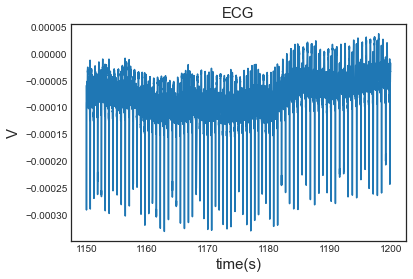

In [30]:

t_ecg = raw_dict['ecg_time']
v_ecg = raw_dict['ecg']

t_mask = (t_ecg>=t_start) & (t_ecg<t_end)

t_ecg = t_ecg[t_mask]
v_ecg = v_ecg[t_mask]
plt.plot(t_ecg, v_ecg)
plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel('V', fontsize=fontsize)
plt.title('ECG', fontsize=fontsize)

# ACC (raw)

In [31]:
raw_dict['accel_time'].min(), raw_dict['accel_time'].max()

(10.627685546875, 5680.69921875)

Text(0.5, 1.0, 'ACC')

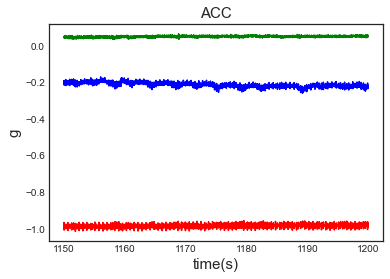

In [32]:

t_acc = raw_dict['accel_time']
v_acc_x= raw_dict['accel_x']
v_acc_y= raw_dict['accel_y']
v_acc_z= raw_dict['accel_z']
t_acc.shape, v_acc_x.shape
# t_mask = (t_acc>50) & (t_acc<90)
t_mask = (t_acc>=t_start) & (t_acc<t_end)

t_acc = t_acc[t_mask]
v_acc_x = v_acc_x[t_mask]
v_acc_y = v_acc_y[t_mask]
v_acc_z = v_acc_z[t_mask]
plt.plot(t_acc, v_acc_x, 'r')
plt.plot(t_acc, v_acc_y, 'g')
plt.plot(t_acc, v_acc_z, 'b')

plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel('g', fontsize=fontsize)
plt.title('ACC', fontsize=fontsize)

# PPG array 1 (filtered)

In [33]:
raw_dict['ppg_time'].min(), raw_dict['ppg_time'].max()

(10.6357421875, 5680.69677734375)

Text(0.5, 1.0, 'PPG1')

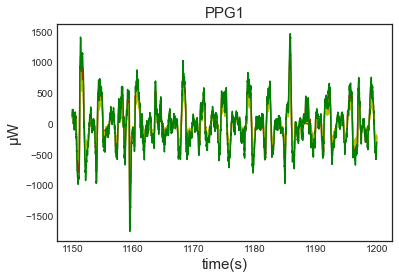

In [34]:

t_ppg = raw_dict['ppg_time']
v_ppg_r_1= raw_dict['ppg_r_1']
v_ppg_ir_1= raw_dict['ppg_ir_1']
v_ppg_g_1= raw_dict['ppg_g_1']

t_mask = (t_ppg>=t_start) & (t_ppg<t_end)

def get_smooth(x, N=10):
    return np.convolve(x, np.ones(N)/N, mode='same')

v_ppg_r_1 = v_ppg_r_1-get_smooth(v_ppg_r_1, N=100)
v_ppg_ir_1 = v_ppg_ir_1-get_smooth(v_ppg_ir_1, N=100)
v_ppg_g_1 = v_ppg_g_1-get_smooth(v_ppg_g_1, N=100)

t_ppg = t_ppg[t_mask]
v_ppg_r_1 = v_ppg_r_1[t_mask]
v_ppg_ir_1 = v_ppg_ir_1[t_mask]
v_ppg_g_1 = v_ppg_g_1[t_mask]
plt.plot(t_ppg, v_ppg_r_1, 'r')
plt.plot(t_ppg, v_ppg_ir_1, 'y')
plt.plot(t_ppg, v_ppg_g_1, 'g')


plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel('μW', fontsize=fontsize)
plt.title('PPG1', fontsize=fontsize)

# PPG array 2 (filtered)

Text(0.5, 1.0, 'PPG2')

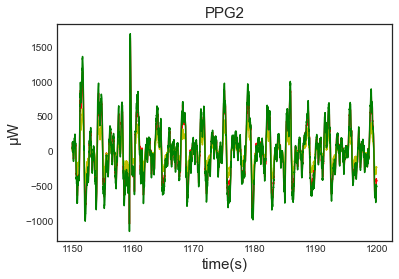

In [35]:

t_ppg = raw_dict['ppg_time']
v_ppg_r_2= raw_dict['ppg_r_2']
v_ppg_ir_2= raw_dict['ppg_ir_2']
v_ppg_g_2= raw_dict['ppg_g_2']

# t_mask = (t_ppg>80) & (t_ppg<90)
# t_mask = (t_ppg>1000) & (t_ppg<1020)

def get_smooth(x, N=10):
    return np.convolve(x, np.ones(N)/N, mode='same')

v_ppg_r_2 = v_ppg_r_2-get_smooth(v_ppg_r_2, N=100)
v_ppg_ir_2 = v_ppg_ir_2-get_smooth(v_ppg_ir_2, N=100)
v_ppg_g_2 = v_ppg_g_2-get_smooth(v_ppg_g_2, N=100)

t_ppg = t_ppg[t_mask]
v_ppg_r_2 = v_ppg_r_2[t_mask]
v_ppg_ir_2 = v_ppg_ir_2[t_mask]
v_ppg_g_2 = v_ppg_g_2[t_mask]
plt.plot(t_ppg, v_ppg_r_2, 'r')
plt.plot(t_ppg, v_ppg_ir_2, 'y')
plt.plot(t_ppg, v_ppg_g_2, 'g')


plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel('μW', fontsize=fontsize)
plt.title('PPG2', fontsize=fontsize)

# Do interpolation

In [36]:
# from stage1_patch import *


In [37]:
FS_RESAMPLE = 500 # Hz


patch_dict = data_interpolation(raw_dict, FS_RESAMPLE=FS_RESAMPLE)


In [38]:
print(list(patch_dict.keys()))

['ECG', 'accelX', 'accelY', 'accelZ', 'ppg_g_1', 'ppg_r_1', 'ppg_ir_1', 'ppg_g_2', 'ppg_r_2', 'ppg_ir_2', 'time', 'subject_id']


In [39]:
patch_color_dict = {
    'ECG': 'SteelBlue',
    'accelX': 'MangoTando',
    'accelY': 'Olive',
    'accelZ': 'Teal',
    'ppg_g_1': 'ForestGreen',
    'ppg_r_1': 'Maroon',
    'ppg_ir_1': 'burntumber',
    'ppg_g_2': 'Green',
    'ppg_r_2': 'Red',
    'ppg_ir_2': 'Brown',
}

In [40]:
# inspect_patch(patch_dict, title_str='raw', VIS_START=14000, VIS_END=14010, show_plot=True)


# filter the signal

In [41]:
patch_filt_dict = get_filt_dict(patch_dict)


Filtering the raw patch signals...
Signal has been resampled to 500.0 Hz
ECG passband: [1, 30] Hz
SCG passband: [1, 25] Hz
PPG passband: [0.35, 4] Hz


In [42]:
patch_filt_dict

{'time': array([0.000000e+00, 2.000000e-03, 4.000000e-03, ..., 5.669904e+03,
        5.669906e+03, 5.669908e+03]),
 'ECG': array([0.00029141, 0.00027383, 0.00024077, ..., 0.00011905, 0.00013193,
        0.00013865]),
 'ppg_ir_1': array([  -73.19398139,   -73.17675766,   -73.15828275, ...,
        -2323.85525283, -2335.89279555, -2341.89048093]),
 'ppg_r_1': array([ -31.75886782,  -31.75115141,  -31.74288488, ..., -102.58401716,
        -103.64628356, -104.14717475]),
 'ppg_g_1': array([-128.40340898, -128.36394401, -128.31779485, ..., -760.72311025,
        -765.68013401, -768.09700632]),
 'ppg_ir_2': array([  -46.37348181,   -46.38730386,   -46.39911278, ...,
        27195.03240613, 27230.76528163, 27248.65782132]),
 'ppg_r_2': array([  -21.87459677,   -21.87961228,   -21.88295214, ...,
        16893.43149287, 16925.19897727, 16941.0925237 ]),
 'ppg_g_2': array([  -78.73293522,   -78.7599896 ,   -78.78279039, ...,
        27160.07865416, 27207.96275352, 27231.87068369]),
 'accelX': ar

In [43]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# inspect_patch(patch_filt_dict, title_str='filterd')
inspect_patch(patch_filt_dict, title_str='filterd', VIS_START=11000, VIS_END=12500, show_plot=True)


IndexError: index -1 is out of bounds for axis 0 with size 0

In [91]:
def inspect_patch_report(df, title_str, outputdir=None, show_plot=False):
    t_dur = df['time'].values[-1] - df['time'].values[0]

    subject_id = df['subject_id'].values[0]
    print('[{}]: {} sec'.format(subject_id, t_dur))

    t_arr =  df['time'].values
    t_arr = t_arr - t_arr[0]
#     print(t_arr.shape, df['ECG'].values.shape)

    ECG = get_padded_filt(df['ECG'].values, filter_padded=1, lowcutoff=FILT_ECG[0], highcutoff=FILT_ECG[1], Fs=FS_RESAMPLE)
    ppg_g = -get_padded_filt(df['ppg_g_2'].values, filter_padded=1, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=FS_RESAMPLE)
    ppg_r = -get_padded_filt(df['ppg_r_2'].values, filter_padded=1, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=FS_RESAMPLE)
    ppg_ir = -get_padded_filt(df['ppg_ir_2'].values, filter_padded=1, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=FS_RESAMPLE)
    accelZ = get_padded_filt(df['accelZ'].values, filter_padded=1, lowcutoff=FILT_SCG[0], highcutoff=FILT_SCG[1], Fs=FS_RESAMPLE)

    print(t_arr.shape, ECG.shape)

    # fig = plt.figure(figsize=(3*t_dur/80, 3*10), dpi=50, facecolor='white')
    fig = plt.figure(figsize=(10, 10), dpi=80, facecolor='white')

    fontsize = 20
    scale_factor = 8
    alpha = 1

    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(t_arr, ECG, color=color_dict[sig_color_dict['ECG_filt']], alpha=0.5 ,zorder=1, label='ECG')

    ax1.set_xlim(t_arr[0],t_arr[-1])
#     ax1.set_title('ECG', fontsize=fontsize)
    ax1.set_ylabel('mV', fontsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.legend(loc='upper right', fontsize=fontsize, frameon=True)


    ax2 = fig.add_subplot(3,1,2)
#     ax2.plot(t_arr, data_dict['accelX'], color=color_dict[colornames[list_sigs.index('accelX')]], alpha=alpha ,zorder=1, label='accelX')
#     ax2.plot(t_arr, data_dict['accelY'], color=color_dict[colornames[list_sigs.index('accelY')]], alpha=alpha ,zorder=1, label='accelY')
    ax2.plot(t_arr, accelZ, color=color_dict[sig_color_dict['accelZ_filt']], alpha=alpha ,zorder=1, label='SCG-DV')
    ax2.set_xlim(t_arr[0],t_arr[-1])
#     ax2.set_title('SCG-DV', fontsize=fontsize)
    ax2.set_ylabel('mg', fontsize=fontsize)
    ax2.tick_params(axis='x', labelsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    ax2.legend(loc='upper right', fontsize=fontsize, frameon=True)

    ax3 = fig.add_subplot(3,1,3)
    ax3.plot(t_arr, ppg_g, color=color_dict[sig_color_dict['ppg_g_2_filt']], alpha=alpha ,zorder=1, label='green PPG')
    ax3.plot(t_arr, ppg_r, color=color_dict[sig_color_dict['ppg_r_2_filt']], alpha=alpha ,zorder=1, label='red PPG')
    ax3.plot(t_arr, ppg_ir, color=color_dict[sig_color_dict['ppg_ir_2_filt']], alpha=alpha ,zorder=1, label='infrared PPG')
    ax3.set_xlim(t_arr[0],t_arr[-1])
#     ax3.set_title('PPG array', fontsize=fontsize)
    ax3.set_ylabel('ppg intensity (uA)', fontsize=fontsize)
    ax3.tick_params(axis='x', labelsize=fontsize)
    ax3.tick_params(axis='y', labelsize=fontsize)
    ax3.legend(loc='upper right', fontsize=fontsize, frameon=True)


    ax3.set_xlabel('time (sec)', fontsize=fontsize)
#     plt.minorticks_on() 

#     ax3.spines['right'].set_visible(False)
#     ax3.spines['top'].set_visible(False)
#     ax3.spines['left'].set_visible(False)
#     ax3.set_tick_params(left = False)

    fig.tight_layout()
    
#     sys.exit()
    
    fig_name = '{}_signl_{}'.format(title_str,subject_id)
    
    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + fig_name+'.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')
        
#     if log_wandb:
#         wandb.log({fig_name: wandb.Image(fig)})

[sub002]: 9.995999999999185 sec
(4999,) (4999,)


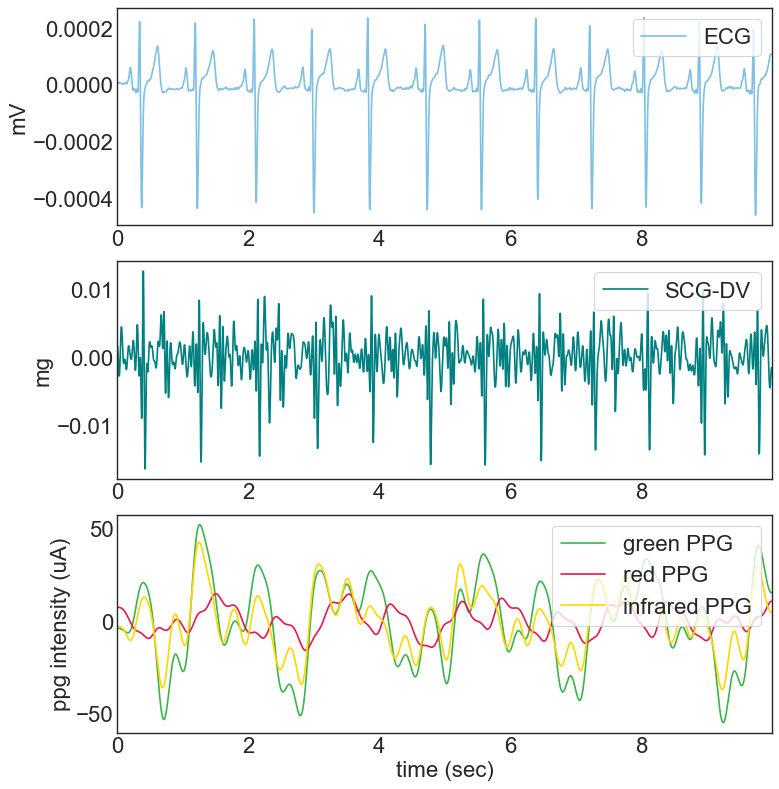

In [115]:
plt_report = True

if plt_report:
#     patch_dict = list_patch_filt[5]
    df = pd.DataFrame.from_dict(patch_dict)
    
    t_start = 4500
    df = df[(df['time'] > t_start) & (df['time'] < t_start+10)]

    inspect_patch_report(df, 'Report', outputdir=outputdir, show_plot=True)